In [1]:
import os
import random
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim.lr_scheduler as lr_scheduler
from torch.autograd import Variable
from collections import deque, namedtuple

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#! pip install swig
#! pip install gymnasium
#! pip install gymnasium[box2d]

In [3]:
env = gym.make("LunarLander-v3", gravity=-10, continuous=False,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode="human")

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)



Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)


In [4]:
state_shape = env.observation_space.shape
state_size = env.observation_space.shape[0]
number_actions = env.action_space.n

In [5]:
print('State shape: ', state_shape)
print('State size: ', state_size)
print('Number of actions: ', number_actions)

State shape:  (8,)
State size:  8
Number of actions:  4


In [6]:

def random_policy(env, state):
    return env.action_space.sample()

state = env.reset()[0]

for counter in range(201):

    env.render()

    #select the action according to the given policy
    action = random_policy(env, state)
    
    #perform the action and store the next state information
    next_state, reward, done, truncated, info = env.step(action)

    if counter % 10 == 0:
        print("Step:", counter, next_state, reward, done, info)
        
env.close()

Step: 0 [-0.01009436  1.4324743  -0.5105347   0.4660997   0.01157735  0.11445676
  0.          0.        ] 0.1858657333372662 False {}
Step: 10 [-0.06027079  1.5266532  -0.50324285  0.33686206  0.11166158  0.21179609
  0.          0.        ] -0.31516889786095703 False {}
Step: 20 [-0.11133957  1.5774624  -0.5272395   0.15763761  0.2108048   0.20768246
  0.          0.        ] -2.0702949754981317 False {}
Step: 30 [-0.16043147  1.5910816  -0.49849743  0.0114089   0.23179713  0.00687036
  0.          0.        ] 0.8760807845223166 False {}
Step: 40 [-0.21322484  1.5685438  -0.5610288  -0.18028833  0.26729608  0.12295918
  0.          0.        ] -0.18347738825332158 False {}
Step: 50 [-0.26904878  1.5115747  -0.5800433  -0.34512576  0.32856005  0.15366141
  0.          0.        ] -0.660436256033903 False {}
Step: 60 [-0.33143336  1.4226122  -0.6731488  -0.47572282  0.42020383  0.22969678
  0.          0.        ] -2.7894439530379302 False {}
Step: 70 [-0.40377063  1.2979972  -0.782957

In [7]:
seed_value = 42

env = gym.make("LunarLander-v3", gravity=-10, continuous=True,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)
env.reset(seed=seed_value)



state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_low = float(env.action_space.low[0])
action_high = float(env.action_space.high[0])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
env.close()

## stable-baselines DDPG

In [ ]:
import gymnasium as gym
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
import numpy as np
import torch


seed_value = 42

env = gym.make("LunarLander-v3", gravity=-10, continuous=True,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)
env.reset(seed=seed_value)

# Get dimensions
n_actions = env.action_space.shape[0]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.2 * np.ones(n_actions))

policy_kwargs = dict(net_arch=[256, 256])


# Define model
model = DDPG(
    "MlpPolicy",
    env,
    action_noise=action_noise,
    policy_kwargs=policy_kwargs,
    verbose=1,
    learning_rate=1e-3,
    buffer_size=1_000_000,
    batch_size=128,
    gamma=0.99,
    tau=0.005,
    train_freq=(1, "step"),
    gradient_steps=1,
    device="auto",  # "cuda" or "cpu"
    seed=seed_value
)

# Track episode rewards
episode_rewards = []
n_eval_episodes = 10
eval_interval = 5000  # evaluate every 5k steps
total_timesteps = 1_000_000
timesteps = 0
eval_results = []

# Helper function for evaluation
def evaluate(model, env, n_episodes=10):
    rewards = []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
        rewards.append(total_reward)
    return np.mean(rewards), rewards

# Train in intervals, evaluate and log
while timesteps < total_timesteps:
    model.learn(total_timesteps=eval_interval, reset_num_timesteps=False)
    timesteps += eval_interval
    mean_reward, rewards = evaluate(model, env, n_episodes=n_eval_episodes)
    episode_rewards.append(mean_reward)
    eval_results.append({"timesteps": timesteps, "mean_reward": mean_reward})
    print(f"Evaluation at step {timesteps}: Mean Reward = {mean_reward:.2f}")

# Save model and close environment
model.save("ddpg_lunar")
env.close()



Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 77.2     |
|    ep_rew_mean     | -408     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 229      |
|    time_elapsed    | 1        |
|    total_timesteps | 309      |
| train/             |          |
|    actor_loss      | 5.05     |
|    critic_loss     | 38.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 208      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -335     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 184      |
|    time_elapsed    | 4        |
|    total_timesteps | 811      |
| train/             |          |
|    actor_loss      | 4.99     |
|    critic_loss     |

In [ ]:
# Reload model and test in human mode
from stable_baselines3 import DDPG
import gymnasium as gym

# Load environment in render mode
test_env = gym.make("LunarLander-v3", gravity=-10, continuous=True,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode="human")
test_env.reset(seed=seed_value)

# Load the model
model = DDPG.load("ddpg_lunar")

# Run a few episodes
for ep in range(10):
    obs, _ = test_env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = test_env.step(action)
        done = terminated or truncated
        total_reward += reward
    print(f"Test Episode {ep+1}: Reward = {total_reward:.2f}")
test_env.close()


Test Episode 1: Reward = 254.68
Test Episode 2: Reward = 281.93
Test Episode 3: Reward = 241.92
Test Episode 4: Reward = -10.94
Test Episode 5: Reward = 285.95
Test Episode 6: Reward = -72.91
Test Episode 7: Reward = 302.26
Test Episode 8: Reward = 280.09
Test Episode 9: Reward = 274.52
Test Episode 10: Reward = 298.05


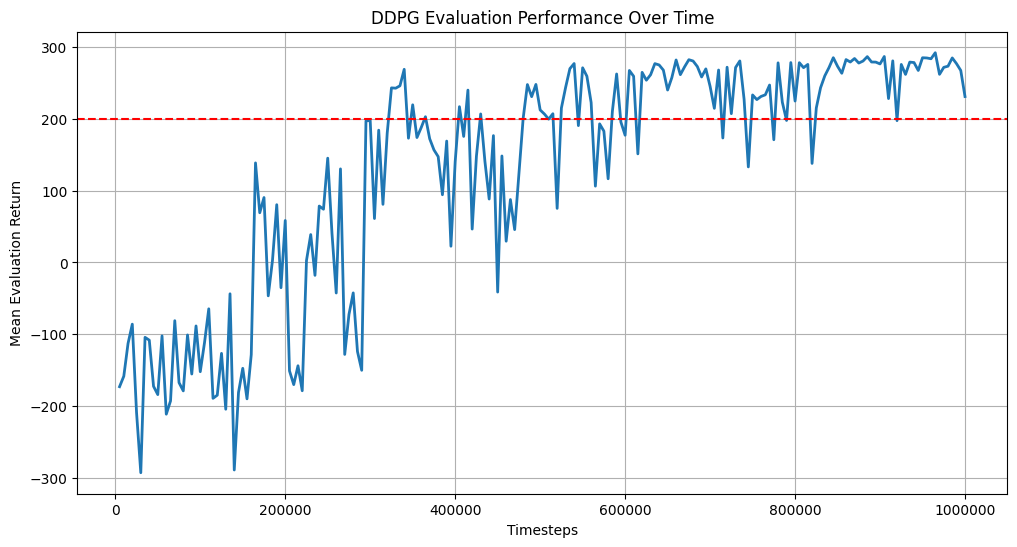

In [ ]:
# Convert to DataFrame
results_df = pd.DataFrame(eval_results)

plt.figure(figsize=(12, 6))
plt.plot(results_df["timesteps"], results_df["mean_reward"], linewidth=2)  # thicker line
plt.axhline(y=200, color='red', linestyle='--', linewidth=1.5)  # red dashed horizontal line at 200
plt.xlabel("Timesteps")
plt.ylabel("Mean Evaluation Return")
plt.title("DDPG Evaluation Performance Over Time")
plt.grid(True)
plt.ticklabel_format(style='plain', axis='x')
plt.show()



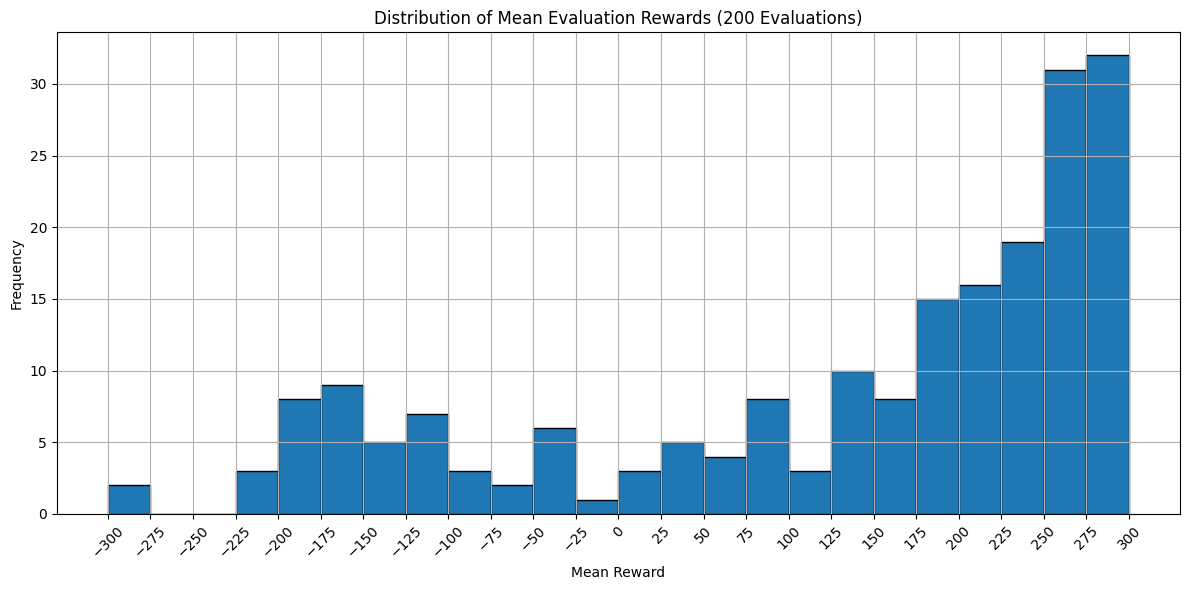

In [ ]:
min_reward = results_df["mean_reward"].min()
max_reward = results_df["mean_reward"].max()

# Create bin edges every 25 units from min to max, adding one extra bin to cover max
bins = np.arange(start=np.floor(min_reward / 25) * 25,
                 stop=np.ceil(max_reward / 25) * 25 + 25,
                 step=25)

plt.figure(figsize=(12, 6))
plt.hist(results_df["mean_reward"], bins=bins, edgecolor='k')
plt.xlabel("Mean Reward")
plt.ylabel("Frequency")
plt.title("Distribution of Mean Evaluation Rewards (200 Evaluations)")
plt.grid(True, axis='x')
plt.grid(True, axis='y', which='both')
plt.xticks(bins, rotation=45)
plt.tight_layout()
plt.show()


# PPO

In [ ]:
from stable_baselines3 import PPO
import gymnasium as gym

In [ ]:
# Test/Evaluate PPO agent using your env
env = gym.make("LunarLander-v3", gravity=-10, continuous=True,
               enable_wind=True, wind_power=15.0, turbulence_power=1.5
    )
env.reset(seed=seed_value)

env.close()

In [ ]:
# Env Properties
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_low = float(env.action_space.low[0])
action_high = float(env.action_space.high[0])

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print('State dimension:', state_dim)
print('Action dimension:', action_dim)
print('Action range:', action_low, 'to', action_high)

The first experiment trains a PPO agent using the default hyperparameters from Stable Baselines3. Every 5,000 steps, the agent is evaluated in a fresh environment and the results are logged to monitor learning progress throughout training.


In [ ]:
# Create PPO model using your existing env
ppo_model = PPO("MlpPolicy", env, verbose=0, tensorboard_log="./ppo_lunar_tensorboard/")

# Train PPO
total_timesteps = 1_000_000
eval_interval = 5000
eval_episodes = 10

episode_rewards = []
eval_results = []
timesteps = 0

def evaluate(model, env, n_episodes=10):
    rewards = []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
        rewards.append(total_reward)
    return np.mean(rewards), rewards

while timesteps < total_timesteps:
    ppo_model.learn(total_timesteps=eval_interval, reset_num_timesteps=False)
    timesteps += eval_interval

    eval_env = gym.make(
        "LunarLander-v3",
        gravity=-10,
        continuous=True,
        enable_wind=True,
        wind_power=15.0,
        turbulence_power=1.5,
    )
    eval_env.reset(seed=seed_value)

    mean_reward, rewards = evaluate(ppo_model, eval_env, n_episodes=eval_episodes)
    episode_rewards.append(mean_reward)
    eval_results.append({"timesteps": timesteps, "mean_reward": mean_reward})

    print(f"Evaluation at step {timesteps}: Mean Reward = {mean_reward:.2f}")

    eval_env.close()

ppo_model.save("ppo_lunar_vanilla")
env.close()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_lunar_tensorboard/PPO_10


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | -359     |
| time/              |          |
|    fps             | 3109     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 103        |
|    ep_rew_mean          | -352       |
| time/                   |            |
|    fps                  | 2149       |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00446542 |
|    clip_fraction        | 0.0354     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.84      |
|    explained_variance   | -0.0004    |
|    learning_rate        | 0.0003     |
|   

In [ ]:
results_df = pd.DataFrame(eval_results)


In [ ]:
test_env = gym.make(
    "LunarLander-v3",
    gravity=-10,
    continuous=True,
    enable_wind=True, 
    wind_power=15.0,
    turbulence_power=1.5,
    render_mode=None  
)
test_env.reset(seed=seed_value)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(results_df["timesteps"], results_df["mean_reward"], linewidth=2)
plt.axhline(y=200, color='red', linestyle='--', linewidth=1.5)
plt.xlabel("Timesteps")
plt.ylabel("Mean Evaluation Return")
plt.title("PPO (Default) Evaluation Performance Over Time")
plt.grid(True)
plt.ticklabel_format(style='plain', axis='x')
plt.show()

In [ ]:
min_reward = results_df["mean_reward"].min()
max_reward = results_df["mean_reward"].max()
bins = np.arange(
    start=np.floor(min_reward / 25) * 25,
    stop=np.ceil(max_reward / 25) * 25 + 25,
    step=25
)
plt.figure(figsize=(12, 6))
plt.hist(results_df["mean_reward"], bins=bins, edgecolor='k')
plt.xlabel("Mean Reward")
plt.ylabel("Frequency")
plt.title("PPO (Default): Distribution of Mean Evaluation Rewards")
plt.grid(True, axis='x')
plt.grid(True, axis='y', which='both')
plt.xticks(bins, rotation=45)
plt.tight_layout()
plt.show()


The second experiment explores the impact of custom hyperparameters. In this setup:
- The neural network is deeper (two layers of 256 units for both policy and value)
- Batch size and rollout length are increased
- Learning rate and entropy coefficient are decreased
- More epochs are used per update

The goal is to determine whether these adjustments lead to faster learning or higher average rewards compared to the default setup.


In [ ]:
env = gym.make(
    "LunarLander-v3",
    gravity=-10,
    continuous=True,
    enable_wind=True,
    wind_power=15.0,
    turbulence_power=1.5
)
env.reset(seed=seed_value)

In [ ]:
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print('State dimension:', state_dim)
print('Action dimension:', action_dim)
print('Action range:', action_low, 'to', action_high)

In [ ]:
ppo_model_custom = PPO(
    "MlpPolicy",
    env,
    n_steps=4096,           # Larger rollout for better GAE estimation
    batch_size=256,         # Larger minibatch
    gae_lambda=0.97,        # Slightly lower for less bias, more variance
    gamma=0.99,             # Discount factor
    ent_coef=0.005,         # Less entropy bonus
    learning_rate=1e-4,     # Lower LR for more stable convergence
    n_epochs=20,            # More epochs
    clip_range=0.2,         # Default
    verbose=1,
    tensorboard_log="./ppo_lunar_tensorboard/"
    )

In [ ]:
total_timesteps = 1_000_000
eval_interval = 5000
eval_episodes = 10

episode_rewards_custom = []
eval_results_custom = []
timesteps = 0

while timesteps < total_timesteps:
    ppo_model_custom.learn(total_timesteps=eval_interval, reset_num_timesteps=False)
    timesteps += eval_interval

    eval_env = gym.make(
        "LunarLander-v3",
        gravity=-10,
        continuous=True,
        enable_wind=True,
        wind_power=15.0,
        turbulence_power=1.5,
    )
    eval_env.reset(seed=seed_value)

    mean_reward, rewards = evaluate(ppo_model_custom, eval_env, n_episodes=eval_episodes)
    episode_rewards_custom.append(mean_reward)
    eval_results_custom.append({"timesteps": timesteps, "mean_reward": mean_reward})

    print(f"Custom PPO - Evaluation at step {timesteps}: Mean Reward = {mean_reward:.2f}")

    eval_env.close()

ppo_model_custom.save("ppo_lunar_custom")
env.close()

In [ ]:
results_df_custom = pd.DataFrame(eval_results_custom)

In [ ]:
test_env = gym.make(
    "LunarLander-v3",
    gravity=-10,
    continuous=True,
    enable_wind=True,
    wind_power=15.0,
    turbulence_power=1.5,
    render_mode="human"
)
test_env.reset(seed=seed_value)

# Load the model (already saved previously, or use the variable from training)
ppo_model = PPO.load("ppo_lunar_vanilla")

# Run and render a few episodes
for ep in range(10):
    obs, _ = test_env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = ppo_model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = test_env.step(action)
        done = terminated or truncated
        total_reward += reward
    print(f"Test Episode {ep+1}: Reward = {total_reward:.2f}")
test_env.close()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(results_df_custom["timesteps"], results_df_custom["mean_reward"], linewidth=2)
plt.axhline(y=200, color='red', linestyle='--', linewidth=1.5)
plt.xlabel("Timesteps")
plt.ylabel("Mean Evaluation Return")
plt.title("PPO (Custom) Evaluation Performance Over Time")
plt.grid(True)
plt.ticklabel_format(style='plain', axis='x')
plt.show()


In [ ]:
min_reward_custom = results_df_custom["mean_reward"].min()
max_reward_custom = results_df_custom["mean_reward"].max()
bins_custom = np.arange(
    start=np.floor(min_reward_custom / 25) * 25,
    stop=np.ceil(max_reward_custom / 25) * 25 + 25,
    step=25
)
plt.figure(figsize=(12, 6))
plt.hist(results_df_custom["mean_reward"], bins=bins_custom, edgecolor='k')
plt.xlabel("Mean Reward")
plt.ylabel("Frequency")
plt.title("PPO (Custom): Distribution of Mean Evaluation Rewards")
plt.grid(True, axis='x')
plt.grid(True, axis='y', which='both')
plt.xticks(bins_custom, rotation=45)
plt.tight_layout()
plt.show()